In [1]:
!pip install scikit-surprise

In [3]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from nltk.corpus import stopwords
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
import surprise
from surprise import Reader, Dataset, SVD
from surprise import accuracy
from surprise.model_selection import train_test_split

import warnings; warnings.simplefilter('ignore')

In [5]:
md = pd. read_csv('movies_metadata.csv')
md.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [6]:
# Aggiunta valutazione randomica nel dataset md
import random

randomlist=[]
for i in range(0, 45466):
    n = random.randint(0,5)
    randomlist.append(n)

md.insert(loc=1, column='ratings', value=randomlist)

md

,adult,ratings,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,4,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,2,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,5,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,1,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,5,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,4,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,4,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,3,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [7]:
# Aggiunto userId nel dataset md
listUserId=[]

for i in range (0,45466):
    n = random.randint(0,670)
    listUserId.append(n)

md.insert(loc=2, column='userId', value=listUserId)

md

,adult,ratings,userId,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,4,503,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,2,449,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,5,473,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,1,582,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,5,70,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,4,657,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,4,203,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,5,655,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,3,353,NaN,0,[],NaN,227506,tt0008536,en,...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [150]:
utente = input("inserisci id utente : NUMERO COMPRESO TRA 0 E 671")
def verificaUtente(utente):
    for i in range(0, len(md)-1):
        if ( int(utente) == md.userId[i]):
            print("id = ", utente)
            return 1
    return 0

In [151]:
verifica = verificaUtente(utente)
if (verifica == 0):
    print("utente inserito non presente nel dataset, riprovare")

id =  8


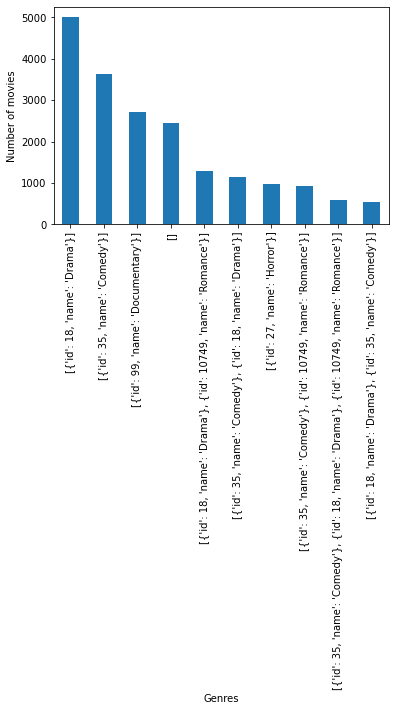

In [152]:
# Numero di film con un determinato genere
Genres=md.genres
Genres=Genres.apply(pd.Series).stack(level=-1,dropna=True)
Genres.value_counts().head(10).plot(kind='bar')
plt.xlabel('Genres')
plt.ylabel('Number of movies')
plt.savefig('1.png',dpi=300,bbox_inches='tight')
plt.show()

In [153]:
md['genres'] = md['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [154]:
vote_counts = md[md['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = md[md['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
C

5.244896612406511

In [155]:
m = vote_counts.quantile(0.95)
m

434.0

In [156]:
md['year'] = pd.to_datetime(md['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

In [157]:
qualified = md[(md['vote_count'] >= m) & (md['vote_count'].notnull()) & (md['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']]
qualified['vote_count'] = qualified['vote_count'].astype('int')
qualified['vote_average'] = qualified['vote_average'].astype('int')
qualified.shape

(2274, 6)

In [158]:
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [159]:
qualified['wr'] = qualified.apply(weighted_rating, axis=1)

In [160]:
qualified = qualified.sort_values('wr', ascending=False).head(250)

In [161]:
qualified.head(15)

,title,year,vote_count,vote_average,popularity,genres,wr
15480,Inception,2010,14075,8,29.108149,"[Action, Thriller, Science Fiction, Mystery, A...",7.917588
12481,The Dark Knight,2008,12269,8,123.167259,"[Drama, Action, Crime, Thriller]",7.905871
22879,Interstellar,2014,11187,8,32.213481,"[Adventure, Drama, Science Fiction]",7.897107
2843,Fight Club,1999,9678,8,63.869599,[Drama],7.881753
4863,The Lord of the Rings: The Fellowship of the Ring,2001,8892,8,32.070725,"[Adventure, Fantasy, Action]",7.871787
292,Pulp Fiction,1994,8670,8,140.950236,"[Thriller, Crime]",7.868660
314,The Shawshank Redemption,1994,8358,8,51.645403,"[Drama, Crime]",7.864000
7000,The Lord of the Rings: The Return of the King,2003,8226,8,29.324358,"[Adventure, Fantasy, Action]",7.861927
351,Forrest Gump,1994,8147,8,48.307194,"[Comedy, Drama, Romance]",7.860656
5814,The Lord of the Rings: The Two Towers,2002,7641,8,29.423537,"[Adventure, Fantasy, Action]",7.851924


In [162]:
s = md.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'
gen_md = md.drop('genres', axis=1).join(s)

In [163]:
def build_chart(genre, percentile=0.85):
    df = gen_md[gen_md['genre'] == genre]
    vote_counts = df[df['vote_count'].notnull()]['vote_count'].astype('int')
    vote_averages = df[df['vote_average'].notnull()]['vote_average'].astype('int')
    C = vote_averages.mean()
    m = vote_counts.quantile(percentile)
    
    qualified = df[(df['vote_count'] >= m) & (df['vote_count'].notnull()) & (df['vote_average'].notnull())][['title', 'year', 'vote_count', 'vote_average', 'popularity']]
    qualified['vote_count'] = qualified['vote_count'].astype('int')
    qualified['vote_average'] = qualified['vote_average'].astype('int')
    
    qualified['wr'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('wr', ascending=False).head(250)
    
    return qualified

In [164]:
build_chart('Animation').head(15)


,title,year,vote_count,vote_average,popularity,wr
359,The Lion King,1994,5520,8,21.605761,7.909339
5481,Spirited Away,2001,3968,8,41.048867,7.875933
9698,Howl's Moving Castle,2004,2049,8,16.136048,7.772103
2884,Princess Mononoke,1997,2041,8,17.166725,7.771305
5833,My Neighbor Totoro,1988,1730,8,13.507299,7.735274
40251,Your Name.,2016,1030,8,34.461252,7.589820
5553,Grave of the Fireflies,1988,974,8,0.010902,7.570962
19901,Paperman,2012,734,8,7.198633,7.465676
39386,Piper,2016,487,8,11.243161,7.285132
20779,Wolf Children,2012,483,8,10.249498,7.281198


In [8]:
links_small = pd.read_csv('links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

In [166]:
md = md.drop([19730, 29503, 35587])

In [167]:
md['id'] = md['id'].astype('int')

In [168]:
smd = md[md['id'].isin(links_small)]
smd.shape

(9099, 27)

In [169]:
smd['tagline'] = smd['tagline'].fillna('')
smd['description'] = smd['overview'] + smd['tagline']
smd['description'] = smd['description'].fillna('')

In [170]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(smd['description'])

In [171]:
tfidf_matrix.shape

(9099, 268124)

In [172]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [173]:
cosine_sim[0]

array([1.        , 0.00680476, 0.        , ..., 0.        , 0.00344913,
       0.        ])

In [174]:
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])

In [175]:
def get_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

In [176]:
get_recommendations('The Dark Knight').head(10)

7931                      The Dark Knight Rises
132                              Batman Forever
1113                             Batman Returns
8227    Batman: The Dark Knight Returns, Part 2
7565                 Batman: Under the Red Hood
524                                      Batman
7901                           Batman: Year One
2579               Batman: Mask of the Phantasm
2696                                        JFK
8165    Batman: The Dark Knight Returns, Part 1
Name: title, dtype: object

In [9]:
credits = pd.read_csv('credits.csv')
keywords = pd.read_csv('keywords.csv')
ratings = pd.read_csv('ratings_small.csv')

ratings.head()

,userId,id,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [178]:
# tiene conto solo del genere, e successivamente della popolarita e ratings

credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int')

md = md.merge(credits, on='id')

smd = md[md['id'].isin(links_small)]
smd['soup'] = smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])


In [179]:
# tiene conto del genere, cast, crew e successivamente popolarita e ratings

'''
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
md['id'] = md['id'].astype('int') 
md.shape

md = md.merge(credits, on='id')
md = md.merge(keywords, on='id')

smd = md[md['id'].isin(links_small)]
smd.shape

smd['cast'] = smd['cast'].apply(literal_eval)
smd['crew'] = smd['crew'].apply(literal_eval)
smd['keywords'] = smd['keywords'].apply(literal_eval)
smd['cast_size'] = smd['cast'].apply(lambda x: len(x))
smd['crew_size'] = smd['crew'].apply(lambda x: len(x))
'''

"\nkeywords['id'] = keywords['id'].astype('int')\ncredits['id'] = credits['id'].astype('int')\nmd['id'] = md['id'].astype('int') \nmd.shape\n\nmd = md.merge(credits, on='id')\nmd = md.merge(keywords, on='id')\n\nsmd = md[md['id'].isin(links_small)]\nsmd.shape\n\nsmd['cast'] = smd['cast'].apply(literal_eval)\nsmd['crew'] = smd['crew'].apply(literal_eval)\nsmd['keywords'] = smd['keywords'].apply(literal_eval)\nsmd['cast_size'] = smd['cast'].apply(lambda x: len(x))\nsmd['crew_size'] = smd['crew'].apply(lambda x: len(x))\n"

In [180]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [181]:
'''
smd['director'] = smd['crew'].apply(get_director)
smd['cast'] = smd['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: x[:3] if len(x) >=3 else x)
smd['keywords'] = smd['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
smd['cast'] = smd['cast'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
smd['director'] = smd['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "")))
smd['director'] = smd['director'].apply(lambda x: [x,x, x])
s = smd.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'
'''

'\nsmd[\'director\'] = smd[\'crew\'].apply(get_director)\nsmd[\'cast\'] = smd[\'cast\'].apply(lambda x: [i[\'name\'] for i in x] if isinstance(x, list) else [])\nsmd[\'cast\'] = smd[\'cast\'].apply(lambda x: x[:3] if len(x) >=3 else x)\nsmd[\'keywords\'] = smd[\'keywords\'].apply(lambda x: [i[\'name\'] for i in x] if isinstance(x, list) else [])\nsmd[\'cast\'] = smd[\'cast\'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])\nsmd[\'director\'] = smd[\'director\'].astype(\'str\').apply(lambda x: str.lower(x.replace(" ", "")))\nsmd[\'director\'] = smd[\'director\'].apply(lambda x: [x,x, x])\ns = smd.apply(lambda x: pd.Series(x[\'keywords\']),axis=1).stack().reset_index(level=1, drop=True)\ns.name = \'keyword\'\n'

In [182]:
#s = s.value_counts()
#s[:5]

In [183]:
#s = s[s > 1]

In [184]:
#stemmer = SnowballStemmer('english')
#stemmer.stem('dogs')

In [185]:
def filter_keywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

In [186]:
'''
smd['keywords'] = smd['keywords'].apply(filter_keywords)
smd['keywords'] = smd['keywords'].apply(lambda x: [stemmer.stem(i) for i in x])
smd['keywords'] = smd['keywords'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])
smd['soup'] = smd['keywords'] + smd['cast'] + smd['director'] + smd['genres']
smd['soup'] = smd['soup'].apply(lambda x: ' '.join(x))
count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
count_matrix = count.fit_transform(smd['soup'])
cosine_sim = cosine_similarity(count_matrix, count_matrix)
smd = smd.reset_index()
titles = smd['title']
indices = pd.Series(smd.index, index=smd['title'])
'''

'\nsmd[\'keywords\'] = smd[\'keywords\'].apply(filter_keywords)\nsmd[\'keywords\'] = smd[\'keywords\'].apply(lambda x: [stemmer.stem(i) for i in x])\nsmd[\'keywords\'] = smd[\'keywords\'].apply(lambda x: [str.lower(i.replace(" ", "")) for i in x])\nsmd[\'soup\'] = smd[\'keywords\'] + smd[\'cast\'] + smd[\'director\'] + smd[\'genres\']\nsmd[\'soup\'] = smd[\'soup\'].apply(lambda x: \' \'.join(x))\ncount = CountVectorizer(analyzer=\'word\',ngram_range=(1, 2),min_df=0, stop_words=\'english\')\ncount_matrix = count.fit_transform(smd[\'soup\'])\ncosine_sim = cosine_similarity(count_matrix, count_matrix)\nsmd = smd.reset_index()\ntitles = smd[\'title\']\nindices = pd.Series(smd.index, index=smd[\'title\'])\n'

In [187]:
listaduplicati = get_recommendations('Batman: Mask of the Phantasm').head(10)
print(listaduplicati)

2587             Batman: Mask of the Phantasm
5646                          The Incredibles
7968                              The Snowman
567                 James and the Giant Peach
867           Aladdin and the King of Thieves
1705       An American Tail: Fievel Goes West
4201    Care Bears Movie II: A New Generation
4882                             Brother Bear
5812                               The Hobbit
6553                              Open Season
Name: title, dtype: object


In [188]:
#evita di consigliare nella lista lo stesso film chiesto
def eliminaDuplicati(listaduplicati,title):
   
    listaNonDuplicati = list(listaduplicati)
    for i in listaduplicati:
        if (i == title):    
            listaNonDuplicati.remove(i)
    return listaNonDuplicati

In [189]:
#lista consigliata senza duplicati
eliminaDuplicati(listaduplicati, 'Batman: Mask of the Phantasm')

['The Incredibles',
 'The Snowman',
 'James and the Giant Peach',
 'Aladdin and the King of Thieves',
 'An American Tail: Fievel Goes West',
 'Care Bears Movie II: A New Generation',
 'Brother Bear',
 'The Hobbit',
 'Open Season']

In [190]:
# Popularity and Ratings
def improved_recommendations(title):

    if title not in list(md['title']): print("Film non presente, inserire un altro titolo")
    else: 
        
        idx = indices[title]
        sim_scores = list(enumerate(cosine_sim[idx]))
        sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
        sim_scores = sim_scores[1:26]
        movie_indices = [i[0] for i in sim_scores]

        movies = smd.iloc[movie_indices][['title', 'vote_count', 'vote_average', 'year']]
        vote_counts = movies[movies['vote_count'].notnull()]['vote_count'].astype('int')
        vote_averages = movies[movies['vote_average'].notnull()]['vote_average'].astype('int')
        C = vote_averages.mean()
        m = vote_counts.quantile(0.60)
        qualified = movies[(movies['vote_count'] >= m) & (movies['vote_count'].notnull()) & (movies['vote_average'].notnull())]
        qualified['vote_count'] = qualified['vote_count'].astype('int')
        qualified['vote_average'] = qualified['vote_average'].astype('int')
        qualified['wr'] = qualified.apply(weighted_rating, axis=1)
        qualified = qualified.sort_values('wr', ascending=False).head(10)
        

        return qualified
       

In [191]:
# generi di film che non piacciono all'utente
def userGeneri():
    listId = []
    for i in range(0, len(md)-1):
     
        if ( md.userId[i] == int(utente)):
            if ( md.ratings[i] <= 1):
                listId.append(md.genres[i])
    return listId


In [192]:
listaId = userGeneri()


In [193]:
# split lista dei generi
Lsplit = []
for Lista in listaId:
      for item in Lista:
             
            Lsplit.append(item)


In [194]:
# ritorna il genere piu odiato dall'utente
def conteggioGeneri(Lsplit):
    count = 0
    j = 1
    var = 0
    L = []
    for i in range(0, len(Lsplit)-1):
        for j in range(i+1, len(Lsplit)):
           
            if ( Lsplit[i] == Lsplit[j]):
                count = count +1 
          
        if ( i == 0):
            var = count 
            count = 0

        if ( count > var ): 
            L.append(Lsplit[i]) 
            var = count
            count = 0
       
    return L[(len(L))-1]

    

In [195]:
GenereNO = conteggioGeneri(Lsplit)
GenereNO

'Drama'

In [196]:
listaConsigliata = improved_recommendations('The Dark Knight')
listaConsigliata = listaConsigliata['title'].values

print(listaConsigliata)

['The Dark Knight' 'The French Connection' 'The Fast and the Furious'
 'Magnum Force' 'Gone in Sixty Seconds' 'Swordfish' 'The Score' 'Hackers'
 'Romeo Must Die' 'Kiss of the Dragon']


In [197]:
# elimina dalla lista dei consigli i film di un genere valutato male
def eliminaGenere(listaConsigliata,GenereNO):
    LISTA = list(listaConsigliata)

    for i in listaConsigliata:
        for j in range(0, len(md)-1):
            if ( md.title[j] == i):
                print(" titolo film =",md.title[j]," genere = ", md.genres[j])
                for k in range(0, len(md.genres[j])):  
                    if ( md.genres[j][k] == GenereNO ) : 
                        if ( i in LISTA):    
                            LISTA.remove(i)
                          
    return LISTA

In [198]:
eliminaGenere(listaConsigliata,GenereNO)


 titolo film = The Dark Knight  genere =  ['Drama', 'Action', 'Crime', 'Thriller']
 titolo film = The Dark Knight  genere =  ['Action', 'Crime', 'Drama', 'Thriller']
 titolo film = The French Connection  genere =  ['Action', 'Crime', 'Thriller']
 titolo film = The Fast and the Furious  genere =  ['Action', 'Crime', 'Thriller']
 titolo film = The Fast and the Furious  genere =  ['Action', 'Crime', 'Drama']
 titolo film = Magnum Force  genere =  ['Action', 'Crime', 'Thriller']
 titolo film = Gone in Sixty Seconds  genere =  ['Action', 'Crime', 'Thriller']
 titolo film = Swordfish  genere =  ['Action', 'Crime', 'Thriller']
 titolo film = The Score  genere =  ['Action', 'Crime', 'Thriller']
 titolo film = Hackers  genere =  ['Action', 'Crime', 'Thriller', 'Drama']
 titolo film = Romeo Must Die  genere =  ['Action', 'Crime', 'Thriller']
 titolo film = Kiss of the Dragon  genere =  ['Action', 'Crime', 'Thriller']


['The French Connection',
 'Magnum Force',
 'Gone in Sixty Seconds',
 'Swordfish',
 'The Score',
 'Romeo Must Die',
 'Kiss of the Dragon']

## SVD

In [199]:
from surprise import Reader, Dataset, SVD
from surprise import accuracy
from surprise.model_selection import train_test_split


In [200]:
n_users = md.userId.unique().shape[0]
n_movies = md.id.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_movies))

Number of users = 671 | Number of movies = 45432


In [201]:
data = Dataset.load_from_df(md[['userId', 'id', 'ratings']], Reader())

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.7200


1.7199892942147978

In [202]:
trainset = data.build_full_trainset()
algo.fit(trainset)

In [203]:
algo.predict(1, 302)

Prediction(uid=1, iid=302, r_ui=None, est=2.7851749490034896, details={'was_impossible': False})